# Attempt to implement MLP for forecasting carbon intensity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import time
import sys, os
sys.path.append(os.path.join('..','LibreHardwareMonitor-net472'))
from power_monitor import PowerMonitor

# Dictionary to store execution times for each code block
execution_times = {}
# Dictionary to store power stats for each code block
power_stats = {}

In [2]:

start_time = time.time()
df = pd.read_csv('../data/df_fuel_ckan.csv')
df['DATETIME'] = pd.to_datetime(df['DATETIME'])
df_monthly = df.set_index('DATETIME')['CARBON_INTENSITY'].resample('ME').mean().reset_index()
df_monthly.head()
execution_times['df import'] = time.time() - start_time

In [3]:
start_time = time.time()
def create_features(df):
    df = df.copy()
    # Seasonal Lags: 1 month, 2 months, and 12 months (yearly seasonality)
    for l in [1, 2, 3, 6, 12]:
        df[f'lag_{l}'] = df['CARBON_INTENSITY'].shift(l)
    
    # Add rolling averages
    df['carbon_3m_ma'] = df['CARBON_INTENSITY'].rolling(window=3, min_periods=1).mean()
    df['carbon_6m_ma'] = df['CARBON_INTENSITY'].rolling(window=6, min_periods=1).mean()
    df['carbon_12m_ma'] = df['CARBON_INTENSITY'].rolling(window=12, min_periods=1).mean()
    
    df['month'] = df['DATETIME'].dt.month
    df['year'] = df['DATETIME'].dt.year
    return df

df_features = create_features(df_monthly).dropna()
df_features.head()
execution_times["create_features"] = time.time() - start_time


In [4]:
start_time = time.time()
train = df_features[df_features['year'] <= 2023]
val = df_features[df_features['year'] == 2024]
test = df_features[df_features['year'] == 2025]

X_train = train.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_train = train['CARBON_INTENSITY']

X_val = val.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_val = val['CARBON_INTENSITY']

X_test = test.drop(columns=['DATETIME', 'CARBON_INTENSITY'])
y_test = test['CARBON_INTENSITY']
execution_times["data split"] = time.time() - start_time

In [5]:
start_time = time.time()
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Scale features based on training data only to avoid data leakage
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)

# Scale target (requires reshaping for the scaler)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
execution_times["data scaling"] = time.time() - start_time

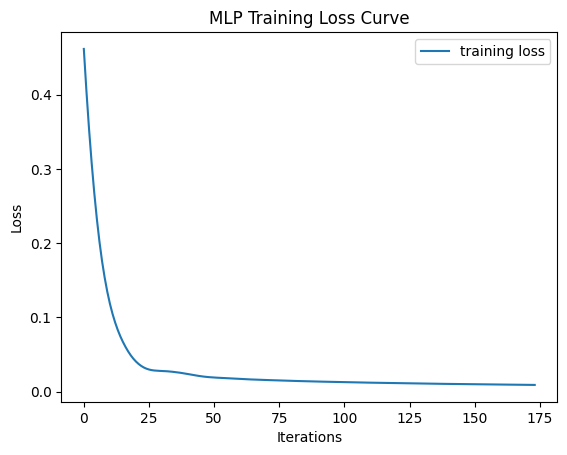

In [6]:
start_time = time.time()
mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32), 
    activation='relu', 
    solver='adam', 
    max_iter=5000, 
    random_state=42,
    early_stopping=True,
    n_iter_no_change=50,
    verbose=False,
)

# sklearn's MLPRegressor.fit does not accept eval_set; early_stopping=True will use an internal validation split
historymlp = mlp.fit(X_train_scaled, y_train_scaled)

plt.plot(historymlp.loss_curve_, label='training loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('MLP Training Loss Curve')
plt.legend()
execution_times["mlp fit"] = time.time() - start_time

In [7]:
start_time = time.time()
y_pred_val_scaled = mlp.predict(X_val_scaled)
# Convert back from scaled units to gCO2/kWh
y_pred_val = scaler_y.inverse_transform(y_pred_val_scaled.reshape(-1, 1)).flatten()

y_pred_test_scaled = mlp.predict(X_test_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.reshape(-1, 1)).flatten()

# Calculate metrics for validation and test sets
val_mse = mean_squared_error(y_val, y_pred_val)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_mse = mean_squared_error(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)
execution_times["mlp prediction"] = time.time() - start_time

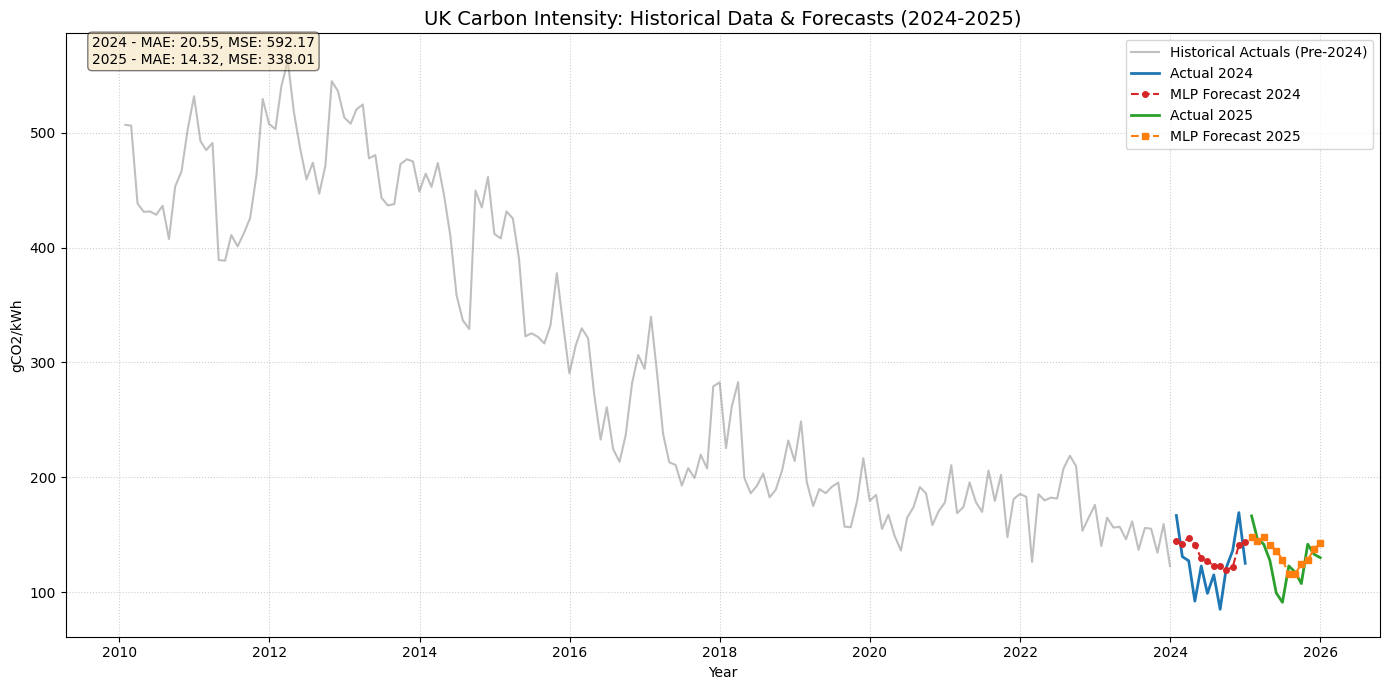

total execution time:  1.390765905380249
{'df import': 0.6929504871368408, 'create_features': 0.009124040603637695, 'data split': 0.005883216857910156, 'data scaling': 0.011176824569702148, 'mlp fit': 0.4712367057800293, 'mlp prediction': 0.006452322006225586, 'plot': 0.19394230842590332}


In [8]:
start_time = time.time()
plt.figure(figsize=(14, 7))

plt.plot(train['DATETIME'], train['CARBON_INTENSITY'], 
         color='gray', alpha=0.5, label='Historical Actuals (Pre-2024)')

plt.plot(val['DATETIME'], val['CARBON_INTENSITY'], 
         color='tab:blue', linewidth=2, label='Actual 2024')

plt.plot(val['DATETIME'], y_pred_val, 
         color='tab:red', linestyle='--', marker='o', markersize=4, label='MLP Forecast 2024')

plt.plot(test['DATETIME'], test['CARBON_INTENSITY'], 
         color='tab:green', linewidth=2, label='Actual 2025')

plt.plot(test['DATETIME'], y_pred_test, 
         color='tab:orange', linestyle='--', marker='s', markersize=4, label='MLP Forecast 2025')

plt.title('UK Carbon Intensity: Historical Data & Forecasts (2024-2025)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('gCO2/kWh')
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

# Add metrics text box
metrics_text = f"2024 - MAE: {val_mae:.2f}, MSE: {val_mse:.2f}\n2025 - MAE: {test_mae:.2f}, MSE: {test_mse:.2f}"
plt.text(0.02, 0.95, metrics_text, 
         fontsize=10, color='black', transform=plt.gca().transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()
execution_times["plot"] = time.time() - start_time
print("total execution time: ", sum(execution_times.values()))
print(execution_times)